In [2]:
import os, os.path, re
import numpy as np
from collections import Counter
from sys import getsizeof
import time
from sklearn.preprocessing import normalize, scale, MinMaxScaler
from sklearn.cluster import *

import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline

data.shape =  (6800, 2)
model =  [linear_(plus2_(hvs_(hyperbola_(X[0])),normal_(linear_(tan_(X[0])))))]
linear_(plus2_(hvs_(hyperbola_(X[0])),normal_(linear_(tan_(X[0])))))
4.17774048463


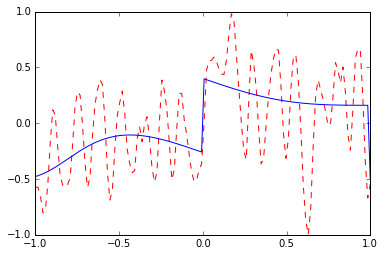

data.shape =  (6800, 2)
model =  [linear_(normal_(normal_(times2_(linear_(tan_(X[0])),times2_(cos_(sqrtl_(normal_(X[0]))),X[0])))))]
linear_(normal_(normal_(times2_(linear_(tan_(X[0])),times2_(cos_(sqrtl_(normal_(X[0]))),X[0])))))
2.35156472272


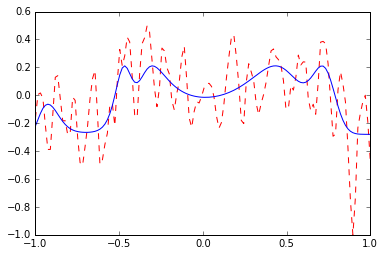

data.shape =  (6800, 2)
model =  [times2_(times2_(linear_(tan_(X[0])),minus2_(plus2_(X[0],X[0]),minus2_(linear_(X[0]),normal_(plus2_(linear_(times2_(X[0],X[0])),linear_(X[0])))))),cos_(expl_(X[0])))]
times2_(times2_(linear_(tan_(X[0])),minus2_(plus2_(X[0],X[0]),minus2_(linear_(X[0]),normal_(plus2_(linear_(times2_(X[0],X[0])),linear_(X[0])))))),cos_(expl_(X[0])))
1.73095676351


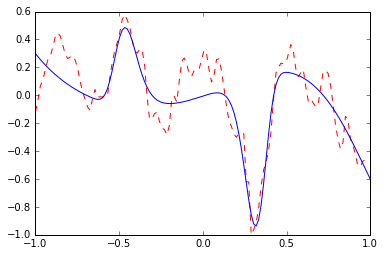

data.shape =  (6800, 2)
model =  [frac2_(linear_(plus2_(normal_(linear_(times2_(X[0],X[0]))),X[0])),expl_(X[0]))]
frac2_(linear_(plus2_(normal_(linear_(times2_(X[0],X[0]))),X[0])),expl_(X[0]))
3.38968095754


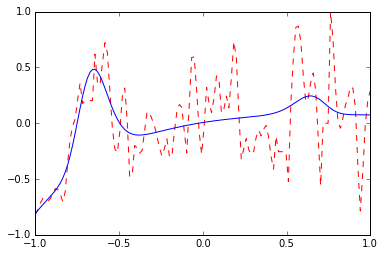

In [44]:
plt.figure(1)
%run ValidateFinalModel.py 'heart_rate' 1
plt.figure(2)
%run ValidateFinalModel.py 'heart_rate' 2
plt.figure(3)
%run ValidateFinalModel.py 'heart_rate' 3
plt.figure(4)
%run ValidateFinalModel.py 'heart_rate' 4


In [ ]:
source_files

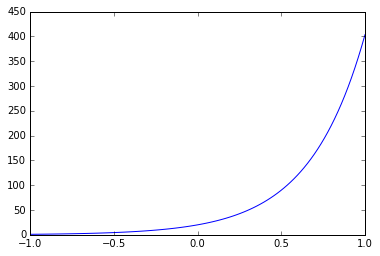

In [29]:
def expl_(w0, w1, x):
    expl_.NumParam = 2
    expl_.NumVars = 1
    return np.exp(x * w1 + w0)
w0 = 3
w1 = 3
x = np.linspace(-1,1,100)
y = expl_(w0, w1, x)
plt.plot(x,y)

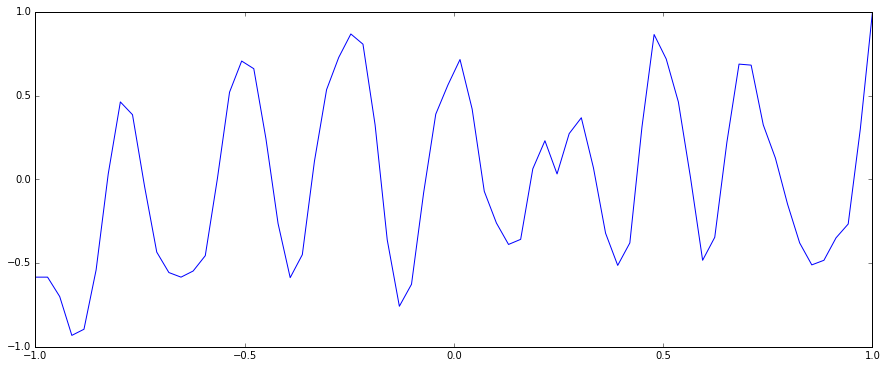

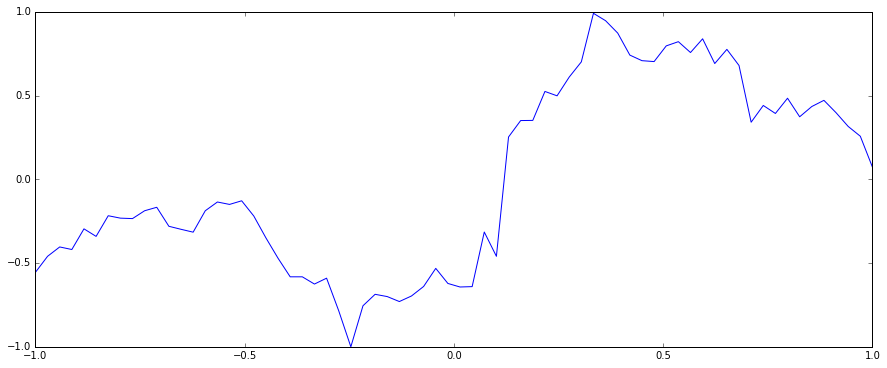

In [40]:
plt.figure(figsize = (15,6))

b = np.loadtxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt')
segment = 0
length = 70
x = np.linspace(-1,1,length)
y = b[segment*length:(segment + 1)*length]
y = y - np.mean(y, axis = 0)
y = np.divide(y, np.max(np.abs(y), axis=0))
plt.plot(x, y)
plt.figure(figsize = (15,6))
b = np.loadtxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple.txt')
segment = 0
length = 70
x = np.linspace(-1,1,length)
y = b[segment*length:(segment + 1)*length]
y = y - np.mean(y, axis = 0)
y = np.divide(y, np.max(np.abs(y), axis=0))
plt.plot(x, y)

In [45]:
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration', 'open_apple']
file_path = 'ts_processing/'
number_of_rows = 3400
for ts_label in ts_labels:
    array = np.loadtxt(file_path + ts_label + '_full.txt')
    np.savetxt(file_path + ts_label + '.txt', array[0:number_of_rows], fmt = '%.3f')

In [27]:
dataset = pd.read_csv('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv')
time_series = dataset['Open']
backup_time_series = time_series

In [48]:
import re
b = 'plus2_(lnl_(linear_(x0)),atana_(linear_(x0)))'
re.sub(r'x(\d+)', r'X[\1]', b)
handle = re.sub(r'X\[(\d+)\]', r'x\1', 'x0')
handle

'x0'

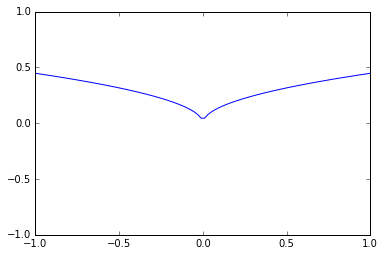

In [15]:
x = np.linspace(-1,1,100)
w0 = 0
w1 = 0.2

def sqrtl_(w0, w1, x):
    sqrtl_.NumParam = 2
    sqrtl_.NumVars = 1

    return np.sqrt(np.abs(x * w1 + w0))

plt.plot(x, sqrtl_(w0, w1, x))
plt.axis([-1, 1, -1, 1])
plt.show()

In [25]:
files_path = 'ts_processing/'
ts_labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
ts_labels = sorted(ts_labels)

number_ts_pieces = len(os.listdir(files_path)) / len(ts_labels)
# if the number is not divided 
if abs(number_ts_pieces - round(number_ts_pieces)) > 0:
    print('ERROR: invalid number of files in ', files_path)
else:
    number_ts_pieces = int(number_ts_pieces)    

def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

file_names = sorted(os.listdir(files_path), key=natural_keys)

ERROR: invalid number of files in  ts_processing/


In [26]:
# set of labels of ts to classify
# labels = chest_volume, heart_rate, oxygen_concentration
labels = ['chest_volume', 'heart_rate', 'oxygen_concentration']
# locations of the ts
root_path = '/MVR_py/ts_processing/'
# extension of files containing data about ts
extension = '.txt'
# folder for output files
where_to_store_models = 'collected_models2/'
# specifies number of segments for ts to be split on
number_of_segments = 340

def retrieve_ts(label):
    
    dataset_filename     = '/data/data_to_fit.txt'
    init_models_filename = '/data/init_models.txt'
    
    
    
    DATA_LOCAL_PATH = root_path
    script_dir = os.path.dirname('__file__')
    parent_dir = os.path.abspath(os.path.join(script_dir, os.pardir))
    DATA_FULL_PATH = parent_dir + DATA_LOCAL_PATH + label + extension
    # retrieve the data to fit from the specified file
    data_to_fit = np.loadtxt(DATA_FULL_PATH, delimiter = ',')
    data_to_fit = np.vstack((data_to_fit, np.linspace(0,1, len(data_to_fit)))).T
    return data_to_fit



In [27]:
def get_segment_of_ts(data, index_of_segment, length_of_segments):
    return data[index_of_segment * length_of_segments : (index_of_segment + 1) * length_of_segments, :]

ts_label = oxygen_concentration ; index_of_segment = 0


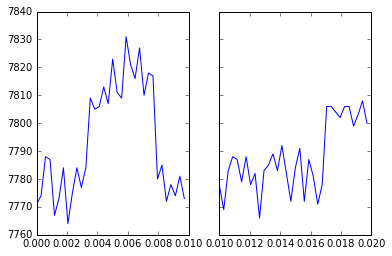

In [28]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

index_of_segment = 0
data = retrieve_ts('oxygen_concentration')
segment = get_segment_of_ts(data, 0, 34)
X = segment[:,1]
y = segment[:,0]

ax1.plot(X,y)

index_of_segment = 0

print("ts_label =", 'oxygen_concentration', "; index_of_segment =", index_of_segment)

data = retrieve_ts('oxygen_concentration')
segment = get_segment_of_ts(data, 1, 34)
X = segment[:,1]
y = segment[:,0]
ax2.plot(X,y)
plt.show()



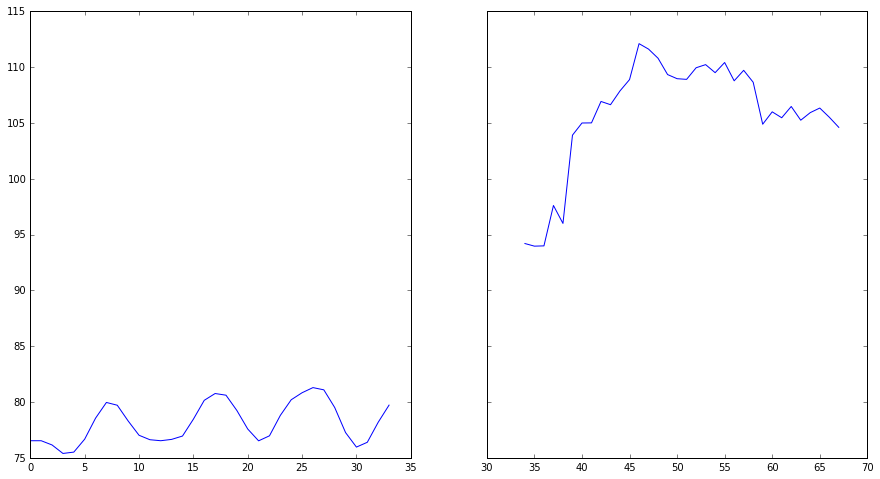

In [41]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/heart_rate.txt', 'r')
data = np.loadtxt(file) 
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
f.set_figheight(8)
f.set_figwidth(15)
num_seg = 0
num_rows = 34
ax1.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])
num_seg = 1
ax2.plot(data[num_seg * num_rows : num_seg * num_rows + num_rows,])


In [28]:
np.savetxt('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/ts_processing/open_apple_full.txt', backup_time_series[:], fmt = '%.4f')

ts_label = chest_volume ; index_of_segment = 0


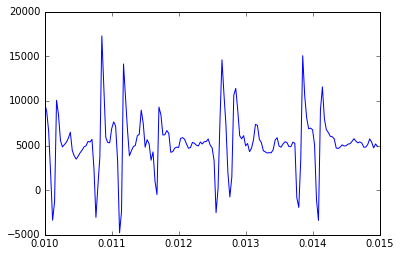

In [51]:
index_of_segment = 0
print("ts_label =", ts_labels[0], "; index_of_segment =", index_of_segment)
data = retrieve_ts(ts_labels[0])
segment = get_segment_of_ts(data, 2, int(data.shape[0] / 200))
X = segment[:,1]
y = segment[:,0]
plt.plot(X,y)
plt.show()

In [5]:
def atoi(text):
    return int(text) if text.isdigit() else text
def natural_keys(text):    
    return [ atoi(c) for c in re.split('(\d+)', text) ]

files_path = 'populations/first_segments2/'
file_names = sorted(os.listdir(files_path), key=natural_keys)
files_path_dest = 'populations/first_segments3/'

if not os.path.isdir(files_path_dest):
    os.makedirs(files_path_dest)

    
for file in file_names:
    number_of_file = int(file[:-4].split('_')[-1])
    if number_of_file >= 51:
        os.rename(files_path + file, files_path_dest + file)

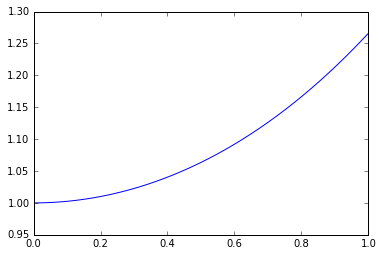

In [33]:
x = np.arange(0,1,.002)
y = np.i0(x)
plt.plot(x,y)

Script dealing with data removing from 'init_models'

In [35]:
file = open('/home/kuluandrej/Ipython3_notebook_projects/MVR_py/data/init_models.txt', 'r')
lines = file.readlines()
file.close()
file = open('/home/kuluandrej/cafedra2015-2016/Experiments on Machine Learning/Datasets/WIKI-AAPL.csv', 'w')
file_dest = open()
required_rows = 5000
for i in range(required_rows):
    file.write(lines[i])
file.close()